In [12]:
import numpy as np
import copy
import json
import math
from glob import glob
import scipy.spatial.distance as sciDist
from tqdm import tqdm
import requests
import time
import itertools
import random
import os
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from itertools import islice
from PIL import Image
import re
from tqdm import tqdm


# Headless simulator version
index = 0 # local server index 
API_ENDPOINT = 'http://localhost:400' + str(index) + '/simulation' # NOT THE LS VERSION
HEADERS = {"Content-Type": "application/json"}
batchCount = 25 # Send this number of samples to MotionGen each time 
speedscale = 1
steps = 360
minsteps = int(steps*20/360)

# Things for 4 bar 
# You can change 
mechType = index
types = ['RRRR', 'RRRP', 'RRPR', 'PRPR']
typeIndex = [49, 64, 155, 175] # to avoid confusion from any other type
couplerCurveIndex = [4, 4, 4, 4]
savePointNumber = [5, 6, 7, 5]
needAddtional = [False, True, True, True]
initStates = np.load("./npy-inputs/" + 'Randpos-.npy')
print("First 5 rows of initStates:")
print(initStates[:5])
print("initStates shape:", initStates.shape)
errCtr = 0
batch = []
batchSaveStr = []
batchSaveNpyStr = []


# The transformation 
#np.save(saveDir + name + ' ' + types[index], param)
saveDir = os.path.abspath("./outputs-4bar/" + types[index] )
saveDirNpy = os.path.abspath("./outputs-4bar/" + types[index] + "-npy")
print(saveDir, saveDirNpy)

First 5 rows of initStates:
[[-9.65019458  7.83146534 -4.30277665 -4.02047245  5.84068521 -3.51058805
   7.29420773 -1.04974736  0.96459813 -2.8565601  -7.75375949 -7.1620569
  -1.10081847  4.6396045  -0.79797544  1.85488818 -3.26572285 -0.91144358
  -6.25744454 -1.82329573 -7.3579592  -9.2577937 ]
 [-8.36024338 -5.73120098  0.90458527  3.10132697  1.77575832  1.49967174
  -3.30629365 -2.38855123 -1.96718616  3.58649664 -7.07647159  5.77568437
  -9.25145889  2.27260775 -6.95864349  5.437541   -4.7376192   5.4393846
  -4.25095303  3.03358748  9.01177677  8.36948685]
 [-6.7043324  -3.24412579 -8.19866068  3.85676664  3.59829384  8.1833134
  -3.87848067 -6.35784988 -9.30444381 -2.59601899  9.25694761  1.5849068
   7.79120699  0.35399657  4.56201843 -2.34422279  9.83510701 -2.14728536
  -7.1466911   8.14040841 -8.78450732 -8.16714112]
 [-0.66458027 -9.98405392  3.78815664 -2.38467841  4.25070088  2.13524747
   8.52854248 -8.40194421  2.3301147   1.98720367 -2.94121372 -3.24597577
  -9.6893

In [13]:
# good old ones 

def isValid(seq):
    if len(seq.shape) == 2:
        isVal = np.var(seq[:,0]) <= 5e-3 and np.var(seq[:,1]) <= 5e-3
    else:
        isVal = len(seq) == 0 or np.var(seq) <= 5e-3

    if isVal:
        return False
    else:
        return True


def get_pca_inclination(qx, qy, ax=None, label=''):
    """ Performs the PCA
        Return transformation matrix
    """
    cx = np.mean(qx)
    cy = np.mean(qy)
    covar_xx = np.sum((qx - cx)*(qx - cx))/len(qx)
    covar_xy = np.sum((qx - cx)*(qy - cy))/len(qx)
    covar_yx = np.sum((qy - cy)*(qx - cx))/len(qx)
    covar_yy = np.sum((qy - cy)*(qy - cy))/len(qx)
    covar = np.array([[covar_xx, covar_xy],[covar_yx, covar_yy]])
    eig_val, eig_vec= np.linalg.eig(covar)

    # Inclination of major principal axis w.r.t. x axis
    if eig_val[0] > eig_val[1]:
        phi= np.arctan2(eig_vec[1,0], eig_vec[0,0])
    else:
        phi= np.arctan2(eig_vec[1,1], eig_vec[0,1])

    return phi


def get_normalize_curve(jd, steps=None, rotations=1, normalize=True, transformParas=None):
    jd = np.array(jd)
    joint_data_n, x_mean, y_mean, denom, phi = [], None, None, None, None
    if isValid(jd):
        if steps:
            sample_indices = np.linspace(0, jd.shape[0]-1, steps, dtype=np.int32)
            jd = jd[sample_indices,:]
        if normalize:
            if not transformParas:
                x_mean = np.mean(jd[:,0], axis=0, keepdims=True)
                y_mean = np.mean(jd[:,1], axis=0, keepdims=True)
            else:
                x_mean, y_mean, denom, phi = transformParas
            jd[:,0] = jd[:,0] - x_mean
            jd[:,1] = jd[:,1] - y_mean

            if not transformParas:
                denom = np.sqrt(np.var(jd[:,0], axis=0, keepdims=True) + np.var(jd[:,1], axis=0, keepdims=True))
                denom = np.expand_dims(denom, axis=1)
            jd = jd / denom
            t = 0
        if not transformParas:
            phi = -get_pca_inclination(jd[:,0], jd[:,1])
        jd[:,0], jd[:, 1] = rotate_curve(jd, phi)
        for tt in range(rotations):
            joint_data_n.append(jd.copy())
            if rotations > 1:
                jd[:,0], jd[:,1] = rotate_curve(jd, t)
                t = 2*np.pi/rotations

    return joint_data_n, x_mean, y_mean, denom, phi


def rotate_curve(cur, theta):
    cpx = cur[:,0]*np.cos(theta) - cur[:,1]*np.sin(theta)
    cpy = cur[:,0]*np.sin(theta) + cur[:,1]*np.cos(theta)
    return cpx, cpy


def digitize_seq(nums, minlim, maxlim, bin_size=64):
    bins = np.linspace(minlim, maxlim, bin_size-1)
    nums_indices = np.digitize(nums, bins)
    return nums_indices


def get_normalize_joint_data_wrt_one_curve(joint_data, ref_ind = 4):
    ''' input s = [num_curves, num_points, 2]
    '''
    joint_data_n = []
    s = np.array(joint_data)
    if isValid(s[ref_ind]):
        x_mean = np.mean(s[ref_ind:ref_ind+1,:,0], axis=1, keepdims=True)
        y_mean = np.mean(s[ref_ind:ref_ind+1,:,1], axis=1, keepdims=True)
        s[:,:,0] = s[:,:,0] - x_mean
        s[:,:,1] = s[:,:,1] - y_mean
        denom = np.sqrt(np.var(s[ref_ind:ref_ind+1,:,0], axis=1, keepdims=True) + np.var(s[ref_ind:ref_ind+1,:,1], axis=1, keepdims=True))
        denom = np.expand_dims(denom, axis=2) #is this scale? 
        s = s / denom
        phi = -get_pca_inclination(s[ref_ind:ref_ind+1,:,0], s[ref_ind:ref_ind+1,:,1])
        for i in range(s.shape[0]):
            s[i,:,0], s[i,:,1] = rotate_curve(s[i], phi)
    else:
        return s, [None, None, None, None], False

    # s has a shape of (j_num, state, dim)
    return s, [x_mean[0][0], y_mean[0][0], denom[0][0][0], phi], True # tx, ty, scaling, rotation angle 


##############################################################################################
# There are some other necessary transformations. (x_mean, y_mean, phi, denom) are from get_normalize_curve. 
##############################################################################################
def get_image_from_point_cloud(points, xylim, im_size, inverted = True, label=None):
    mat = np.zeros((im_size, im_size, 1), dtype=np.uint8)
    x = digitize_seq(points[:,0], -xylim, xylim, im_size)
    if inverted:
        y = digitize_seq(points[:,1]*-1, -xylim, xylim, im_size)
        mat[y, x, 0] = 1
    else:
        y = digitize_seq(points[:,1], -xylim, xylim, im_size)
        mat[x, y, 0] = 1
    return mat


def process_mech_102723(jointData, ref_ind, im_size = 64, xylim = 3.5, inverted = True, swapAxes = True):
    paras = None

    # It is possible the jointData format is (angles, joint, (x, y)). 
    # You should put a True if this happens. (This is how files are saved).
    # I literally don't understand why I saved jointData with a shape of (angles, joint, (x, y)) 
    if swapAxes:
        jointData = np.swapaxes(jointData, 0, 1)

    # This converts all 
    jointData, paras, success = get_normalize_joint_data_wrt_one_curve(jointData, ref_ind= ref_ind)

    # jointData format from now on becomes np.array with a shape of (joint, curve_length, dimension)
    jointData = np.array(jointData)

    if success:
        # get binaryImage 
        jd = jointData[ref_ind]
        mat = get_image_from_point_cloud(jd, xylim=xylim, im_size=im_size, inverted=inverted)
        return mat, paras, success
    else: 
        return None, None, success


def calc_dist(coord):
    # Calculate differences using broadcasting
    diffs = coord[:, np.newaxis, :] - coord[np.newaxis, :, :]
    squared_dists = np.sum(diffs ** 2, axis=2)

    # Extract the upper triangle indices where i < j
    i, j = np.triu_indices(len(coord), k=1)
    dist_arr = np.sqrt(squared_dists[i, j])
    dist_arr = dist_arr/min(dist_arr)
    return np.round(dist_arr, 2)

In [14]:
# An even better version of normalization method (it can be slower sometimes)
# Uses reflection correction (contributed by the paper Geometric Invariant Curve and Surface Normalization)  
# Thanks to Zhijie who noticed these two can be used together. 
##############################################################################################

def rotate_curve(curve, phi):
    infunction_scale = 100
    # curve is scaled 100 times for numerical accuracy 
    # incoming curve shape: (n,2)
    x = curve[:, 0] * infunction_scale
    y = curve[:, 1] * infunction_scale
    # Compute the rotated coordinates
    x_rotated = x * np.cos(phi) - y * np.sin(phi)
    y_rotated = x * np.sin(phi) + y * np.cos(phi)
    # Combine the rotated coordinates into a new curve
    rotated_curve = np.column_stack((x_rotated, y_rotated))
    return rotated_curve/infunction_scale


def center_data(X):
    """ Center the data by subtracting the mean of each column.
        Return the translated X and the translation matrix 
    """
    m = np.mean(X, axis=0) # (n, 2)
    return X - m, np.matrix([[1, 0, -m[0]], [0, 1, -m[1]], [0, 0, 1]]) # equal to XP this is a translation matrix tranposed  


def scale_data(X, scaling = 0): 
    """ Scale the data according to two different metrics 
        If scaling == 0 (default), scaling method is normalization (average distance 1)
        If otherwise, scaling method is standardization to a certain scale 
        Return the scaled X, and the scaling matrix. 
    """
    if scaling == 0:
        # use variance. 
        denom = np.sqrt(np.var(X[:,0]) + np.var(X[:,1]))
        scaled_curve = X /denom
        ScaleMat = np.matrix([[1/denom, 0, 0], [0, 1/denom, 0], [0, 0, 1]])
    else:
        # Compute the maximum distance from the origin 
        max_distance = np.max(np.linalg.norm(X, axis=1))
        scaled_curve = X * scaling / max_distance
        ScaleMat = np.matrix([[scaling/max_distance, 0, 0], [0, scaling/max_distance, 0], [0, 0, 1]])
    return scaled_curve, ScaleMat


def rotate_data(X, tol = 1e-4, randinit = False): 
    """ Performs the PCA and determines rotation angle phi 
        More precisely it is snapping the greatest principal axis to the X-axis. 
        Return the rotated X and the rotation matrix 
    """
    phiInit = 0
    if randinit:
        phiInit = np.random.rand() * math.pi * 2 

    rotationMatInit = np.matrix([
        [np.cos(phiInit), -np.sin(phiInit), 0], 
        [np.sin(phiInit), np.cos(phiInit), 0],
        [0, 0, 1] 
    ])

    X0 = rotate_curve(X, phiInit)
    cx = np.mean(X0[:,0])
    cy = np.mean(X0[:,1])
    covar_xx = np.sum((X0[:,0] - cx)*(X0[:,0] - cx))/X0.shape[0]
    covar_xy = np.sum((X0[:,0] - cx)*(X0[:,1] - cy))/X0.shape[0]
    covar_yx = np.sum((X0[:,1] - cy)*(X0[:,0] - cx))/X0.shape[0]
    covar_yy = np.sum((X0[:,1] - cy)*(X0[:,1] - cy))/X0.shape[0]
    covar = np.array([[covar_xx, covar_xy],[covar_yx, covar_yy]])

    if np.abs(np.linalg.det(covar)) < tol:
        phi = 0 # why rotate anyway? 
    else:
        eig_val, eig_vec= np.linalg.eig(covar) 
        # Inclination of major principal axis w.r.t. x axis
        # Enforcing the cross-product of the two eigenvectors to be greater than 0. 
        # Not necessary, but it looks clean to do so. 
        # Eigenvector matrix: [a, b], det = crossproduct of b x a
        if np.linalg.det(eig_vec) > 0:
            eig_vec[0,:] = -eig_vec[0,:] # enforcing a x b > 0 
        if eig_val[0] > eig_val[1]:
            phi= np.arctan2(eig_vec[1,0], eig_vec[0,0])
        else:
            phi= np.arctan2(eig_vec[1,1], eig_vec[0,1])
    rotated_curve = rotate_curve(X0, phi)
    rotationMat = np.matrix([
        [np.cos(phi), -np.sin(phi), 0], 
        [np.sin(phi), np.cos(phi), 0],
        [0, 0, 1] 
    ])

    return rotated_curve, np.matmul(rotationMat, rotationMatInit)


def reflect_data(X):
    """ Computes the third order moment and determines the reflections 
        The data must be rotated before this step. 

    """
    # Reflection normalization 
    x_scaled = X[:, 0]
    y_scaled = X[:, 1]

    # see paper Geometric Invariant Curve and Surface Normalization
    # compute the 3rd-order moments 
    m12 = np.sum((x_scaled**1)*(y_scaled**2))
    m21 = np.sum((x_scaled**2)*(y_scaled**1))
    signm12 = np.sign(m12)
    signm21 = np.sign(m21)
    if np.abs(signm12) < 1e-5:
        signm12 = 1
    if np.abs(signm21) < 1e-5:
        signm21 = 1

    reflectionMat = np.array(
        [[signm12, 0],
         [0, signm21]]
    ) 

    if np.abs(m12) > np.abs(m21):
        reflectionMat = np.matmul(np.array([[0,1],[1,0]]), reflectionMat)

    reflected_Curve = np.matmul(reflectionMat, np.array(X).T).T
    reflectionMat = np.matrix(
        [[reflectionMat[0,0], reflectionMat[0,1], 0], 
         [reflectionMat[1,0], reflectionMat[1,1], 0], 
         [0, 0, 1]
        ]
    ) 

    return reflected_Curve, reflectionMat


# Digitization 
def digitize_seq(nums, minlim, maxlim, bin_size=64):
    bins = np.linspace(minlim, maxlim, bin_size-1)
    nums_indices = np.digitize(nums, bins)
    return nums_indices


def get_image_from_point_cloud(points, xylim, im_size, inverted = True, label=None):
    mat = np.zeros((im_size, im_size, 1), dtype=np.uint8)
    x = digitize_seq(points[:,0], -xylim, xylim, im_size)
    if inverted:
        y = digitize_seq(points[:,1]*-1, -xylim, xylim, im_size)
        mat[y, x, 0] = 1
    else:
        y = digitize_seq(points[:,1], -xylim, xylim, im_size)
        mat[x, y, 0] = 1
    return mat


# Returns normalized curve, Transformation matrix, and Success (if determinant is greater than tolerance for numerical stability)
def normalize_data_122223(X, scaling = 0, tol = 1e-8, maxiter = 2):
    X1, M1 = center_data(X) 
    X1, M2 = scale_data(X1, scaling = scaling)
    X1, M3 = rotate_data(X1)
    X1, M4 = reflect_data(X1)
    M = M4*M3*M2*M1 # This is the transformation matrix 

    detVal = np.abs(np.linalg.det(M))
    if detVal*scaling < tol:
        for i in range(maxiter):
            X1, M1 = center_data(X1)
            X1, M2 = scale_data(X1, scaling = scaling)
            X1, M3 = rotate_data(X1, randinit= True)
            X1, M4 = reflect_data(X1)
            if np.abs(np.linalg.det(M)) > tol or detVal*10 < np.abs(np.linalg.det(M)):
                break
    return X1, M4*M3*M2*M1, np.abs(np.linalg.det(M)) > tol


def matmul_jd(jd, mat):
    # input should be (..., ,2)
    # the operation: 
    jd = np.array(jd)
    oldshape = jd.shape
    njd= np.reshape(jd, (-1, 2))
    hc1= np.ones((njd.shape[0], 1))
    njd=np.matrix(np.concatenate([njd, hc1], axis = 1)).transpose()
    njd=np.array((mat*njd).transpose())[:,0:2].reshape(oldshape)
    return njd


# Processing 
# THIS IS THE MAIN FUNCTION YOU NEED (second version) 
# Input is the mechanism and coupler point index (ref_ind), Output is matImg, [<two transformation matrix instead of six parameters>], and Success. 
# NOTICE 1: the parameter has SIX parameters, not four (x, y translation, angle and scale). The addtional parameters are reflectionMat, seqReversed (refrlection matrix and whether or not the sequence is reverse in order)
# NOTICE 2: the transformation matrices are numpy arrays. You need to convert them to lists before converting them into .json format objects. 
# I suggest you save the a, b, c, d, e, f values in the matrix. 
# A transformation matrix is shaped as: 
# [[a, c, e]
#  [b, d, f]
#  [0, 0, 1]]
def process_mech_051524(jointData, ref_ind, im_size = 64, xylim = 3.5, inverted = True):
    # New JD shape is always (states, joints, dimensions)
    paras = None
    # get matrices according to curve. 
    nc, mat, success = normalize_data_122223(jointData[:,ref_ind,:], scaling = 3.5)
    NR_MG = mat # transform original position to normalized position # NR_MG * jointData = normalized joint data
    MG_NR = np.linalg.inv(NR_MG) 

    if success:
        # get binaryImage # rohit's choice on what to save 
        paras = NR_MG
        matImg = get_image_from_point_cloud(nc, xylim=xylim, im_size=im_size, inverted=inverted)
        return matImg, paras, success
    else: 
        return None, None, success

    
def calc_dist(coord):
    # Calculate differences using broadcasting
    diffs = coord[:, np.newaxis, :] - coord[np.newaxis, :, :]
    squared_dists = np.sum(diffs ** 2, axis=2)

    # Extract the upper triangle indices where i < j
    i, j = np.triu_indices(len(coord), k=1)
    dist_arr = np.sqrt(squared_dists[i, j])
    dist_arr = dist_arr/min(dist_arr)
    return np.round(dist_arr, 2)

In [15]:
# String for .jpg image

def format_floats_to_string(float_list):
    formatted_strings = [f"{value:.3f}" for value in float_list]
    result_string = ' '.join(formatted_strings)
    return ' ' + result_string

# Example usage
float_values = [3920, -1.000e-03, 5.393e+00, 1.748e+00, -8.786e+00, 2.079e+00, 5.023e+00, -4.854e+00, 4.230e-01, 5.406e+00, -1.882e+00, -1.388e+00, 0.241, -0.285, 0.455, 0.899, 0.0, 1.0]

formatted_string = format_floats_to_string(float_values)
print(formatted_string)



 3920.000 -0.001 5.393 1.748 -8.786 2.079 5.023 -4.854 0.423 5.406 -1.882 -1.388 0.241 -0.285 0.455 0.899 0.000 1.000


  0%|          | 0/30 [00:00<?, ?it/s]

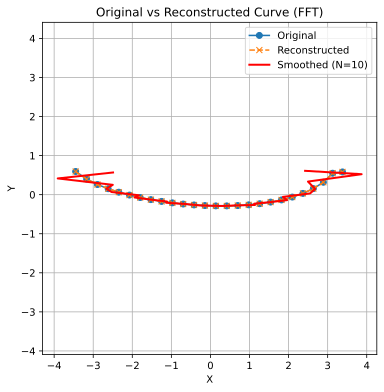

{'total_energy': 65536.0, 'low_energy_ratio': 0.9721289491223167, 'dc_energy_ratio': 3.978966827612855e-33, 'num_power_peaks': 1, 'reconstruction_error_K': 0.16694625146339698, 'ground_fraction': 0.25, 'slope_std': 0.008647999693431349, 'is_closed': False}


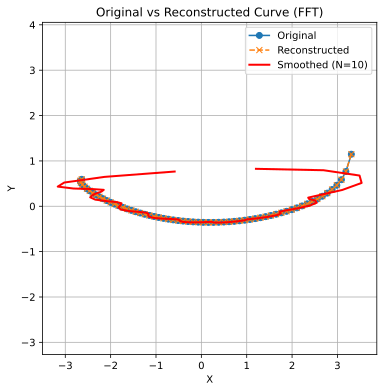

{'total_energy': 65535.999999999985, 'low_energy_ratio': 0.9757287328055471, 'dc_energy_ratio': 5.916665674503731e-33, 'num_power_peaks': 1, 'reconstruction_error_K': 0.15579238490519964, 'ground_fraction': 0.2734375, 'slope_std': 0.011881444011316446, 'is_closed': False}


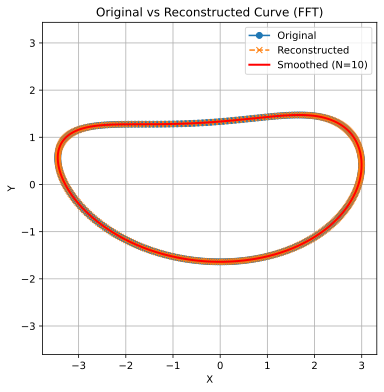

{'total_energy': 65535.99999999997, 'low_energy_ratio': 0.9999994854084914, 'dc_energy_ratio': 1.2911808110294556e-33, 'num_power_peaks': 0, 'reconstruction_error_K': 0.0007173503389001874, 'ground_fraction': 0.1484375, 'slope_std': 0.03220715696223488, 'is_closed': True}


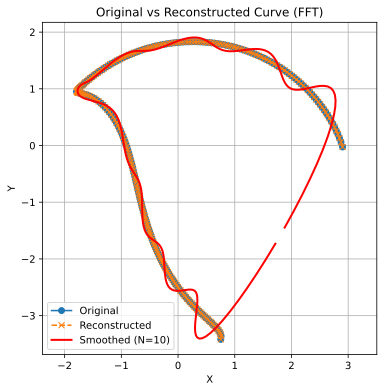

{'total_energy': 65535.99999999998, 'low_energy_ratio': 0.9906844177801389, 'dc_energy_ratio': 2.4446991112921285e-33, 'num_power_peaks': 0, 'reconstruction_error_K': 0.09651726384362515, 'ground_fraction': 0.03125, 'slope_std': 0.02748922868097885, 'is_closed': False}


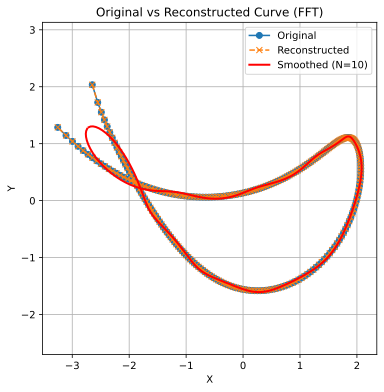

{'total_energy': 65536.00000000001, 'low_energy_ratio': 0.9992991873138314, 'dc_energy_ratio': 4.0188388613087756e-33, 'num_power_peaks': 1, 'reconstruction_error_K': 0.026472866980520475, 'ground_fraction': 0.09765625, 'slope_std': 0.03728209914471818, 'is_closed': False}


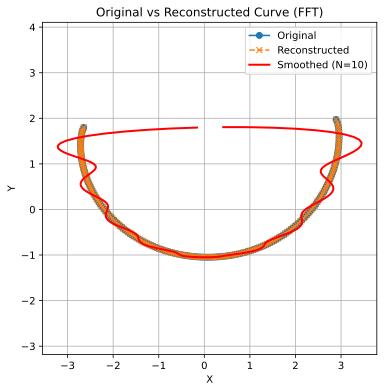

{'total_energy': 65535.999999999985, 'low_energy_ratio': 0.9850514447706122, 'dc_energy_ratio': 1.8808027162591682e-33, 'num_power_peaks': 1, 'reconstruction_error_K': 0.1222642843572311, 'ground_fraction': 0.2109375, 'slope_std': 0.025705556647069354, 'is_closed': False}


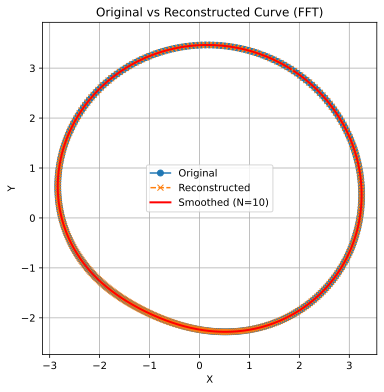

{'total_energy': 65535.99999999999, 'low_energy_ratio': 0.9999999944292153, 'dc_energy_ratio': 4.1611581778941775e-33, 'num_power_peaks': 0, 'reconstruction_error_K': 7.463769023981546e-05, 'ground_fraction': 0.140625, 'slope_std': 0.05008981142926231, 'is_closed': True}


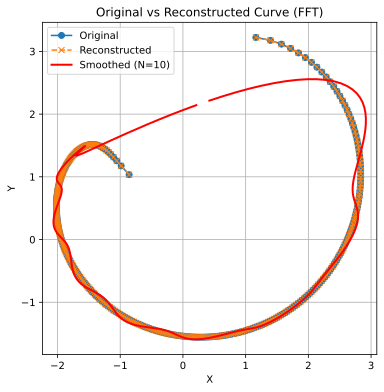

{'total_energy': 65536.00000000003, 'low_energy_ratio': 0.9959709489582098, 'dc_energy_ratio': 8.278724594197171e-33, 'num_power_peaks': 1, 'reconstruction_error_K': 0.06347480635488287, 'ground_fraction': 0.171875, 'slope_std': 0.03455489193537123, 'is_closed': False}


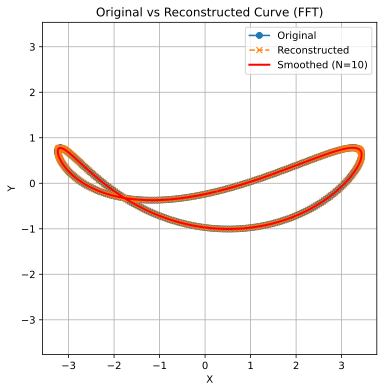

{'total_energy': 65536.00000000001, 'low_energy_ratio': 0.9999874838804632, 'dc_energy_ratio': 9.10702493356059e-34, 'num_power_peaks': 1, 'reconstruction_error_K': 0.0035378128182511166, 'ground_fraction': 0.109375, 'slope_std': 0.026924345450444597, 'is_closed': True}


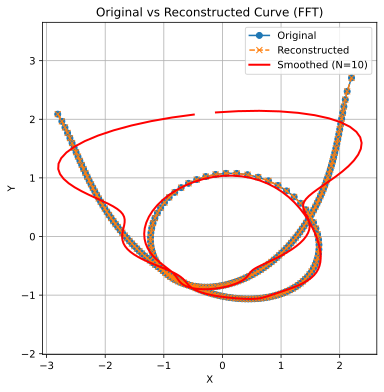

{'total_energy': 65535.999999999985, 'low_energy_ratio': 0.9782625201214008, 'dc_energy_ratio': 1.4800061624028014e-33, 'num_power_peaks': 1, 'reconstruction_error_K': 0.14743635874029393, 'ground_fraction': 0.1015625, 'slope_std': 0.04670497307812023, 'is_closed': False}


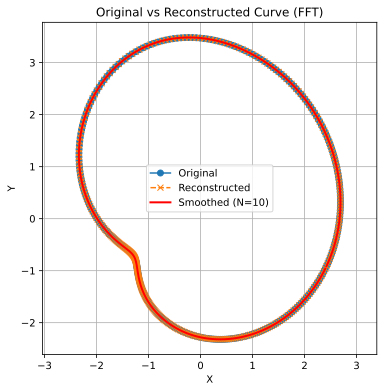

{'total_energy': 65536.0, 'low_energy_ratio': 0.9999993094187318, 'dc_energy_ratio': 7.1200060171290595e-34, 'num_power_peaks': 1, 'reconstruction_error_K': 0.000831012194949716, 'ground_fraction': 0.125, 'slope_std': 0.049316696196191764, 'is_closed': True}


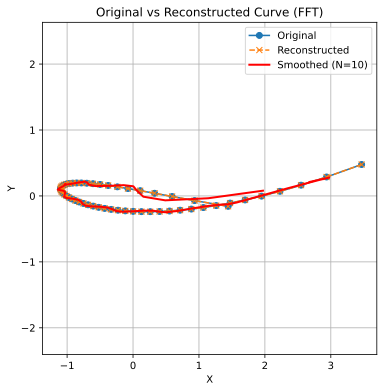

{'total_energy': 65536.00000000001, 'low_energy_ratio': 0.9931358784816813, 'dc_energy_ratio': 5.575569539989748e-33, 'num_power_peaks': 1, 'reconstruction_error_K': 0.08284999407554522, 'ground_fraction': 0.1640625, 'slope_std': 0.0066614827535479565, 'is_closed': False}


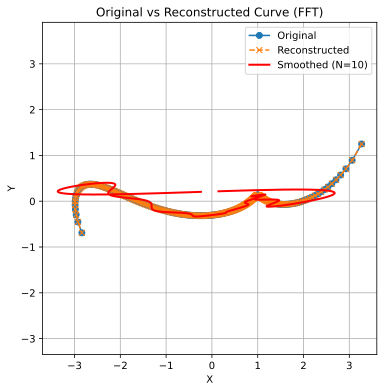

{'total_energy': 65536.0, 'low_energy_ratio': 0.9765654664429881, 'dc_energy_ratio': 1.889372070076662e-34, 'num_power_peaks': 1, 'reconstruction_error_K': 0.15308342025513008, 'ground_fraction': 0.015625, 'slope_std': 0.015459466105454131, 'is_closed': False}


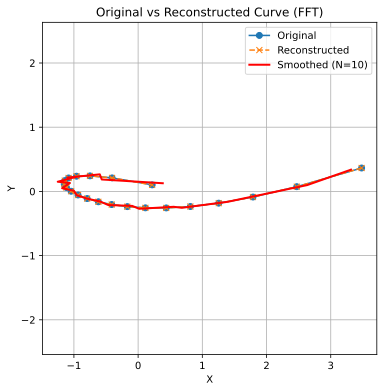

{'total_energy': 65536.0, 'low_energy_ratio': 0.9865738641006777, 'dc_energy_ratio': 2.6502989507227e-34, 'num_power_peaks': 1, 'reconstruction_error_K': 0.11587120392625824, 'ground_fraction': 0.18359375, 'slope_std': 0.006098632592802309, 'is_closed': False}


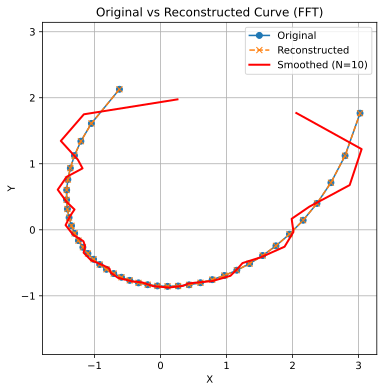

{'total_energy': 65536.00000000003, 'low_energy_ratio': 0.9898664266883536, 'dc_energy_ratio': 3.3675562162356886e-33, 'num_power_peaks': 1, 'reconstruction_error_K': 0.10066565110128171, 'ground_fraction': 0.19140625, 'slope_std': 0.023843842252152928, 'is_closed': False}


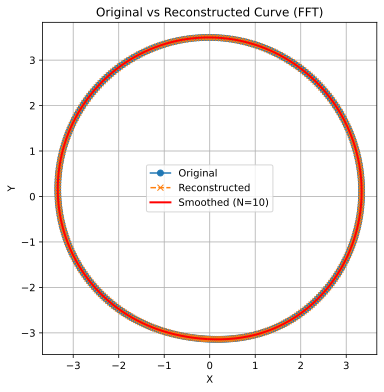

{'total_energy': 65535.99999999998, 'low_energy_ratio': 0.9999997245987543, 'dc_energy_ratio': 3.99085107549967e-34, 'num_power_peaks': 0, 'reconstruction_error_K': 0.000524786857441977, 'ground_fraction': 0.1484375, 'slope_std': 0.05785798139508821, 'is_closed': True}


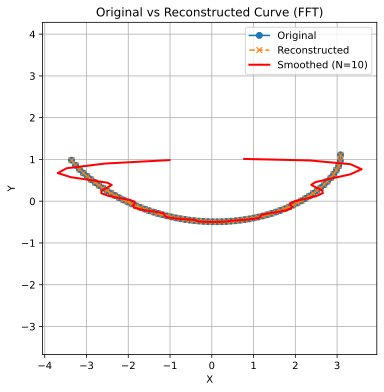

{'total_energy': 65536.0, 'low_energy_ratio': 0.9759355158753751, 'dc_energy_ratio': 7.674758535480559e-33, 'num_power_peaks': 1, 'reconstruction_error_K': 0.15512731585579062, 'ground_fraction': 0.23046875, 'slope_std': 0.014260096682240255, 'is_closed': False}


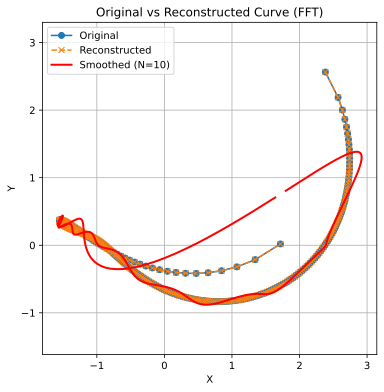

{'total_energy': 65536.00000000001, 'low_energy_ratio': 0.9935484744219557, 'dc_energy_ratio': 8.870045272434814e-33, 'num_power_peaks': 1, 'reconstruction_error_K': 0.08032138929353484, 'ground_fraction': 0.1484375, 'slope_std': 0.024103052942766424, 'is_closed': False}


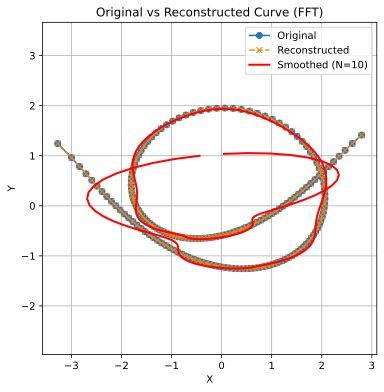

{'total_energy': 65536.00000000001, 'low_energy_ratio': 0.9731672458538994, 'dc_energy_ratio': 2.1043993742008292e-34, 'num_power_peaks': 1, 'reconstruction_error_K': 0.16380706378571505, 'ground_fraction': 0.09375, 'slope_std': 0.04528902720695473, 'is_closed': False}


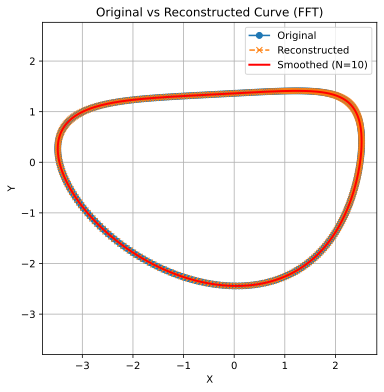

{'total_energy': 65536.0, 'low_energy_ratio': 0.9999993985620338, 'dc_energy_ratio': 1.0998659830262588e-33, 'num_power_peaks': 0, 'reconstruction_error_K': 0.0007755243170489804, 'ground_fraction': 0.1328125, 'slope_std': 0.03770750423423155, 'is_closed': True}


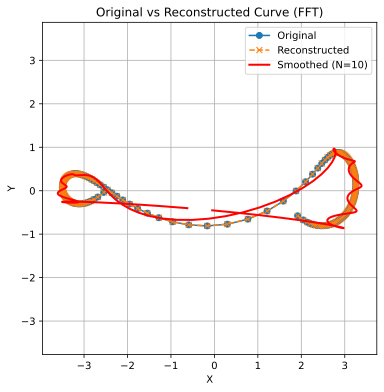

{'total_energy': 65535.999999999985, 'low_energy_ratio': 0.9914048674709821, 'dc_energy_ratio': 1.6969465835829316e-33, 'num_power_peaks': 1, 'reconstruction_error_K': 0.09270993759579882, 'ground_fraction': 0.18359375, 'slope_std': 0.025643750023845058, 'is_closed': False}


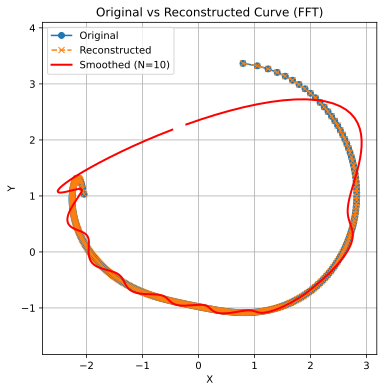

{'total_energy': 65536.00000000001, 'low_energy_ratio': 0.9936487481758962, 'dc_energy_ratio': 7.506095667288698e-33, 'num_power_peaks': 0, 'reconstruction_error_K': 0.07969474150847676, 'ground_fraction': 0.203125, 'slope_std': 0.0298649662815632, 'is_closed': False}


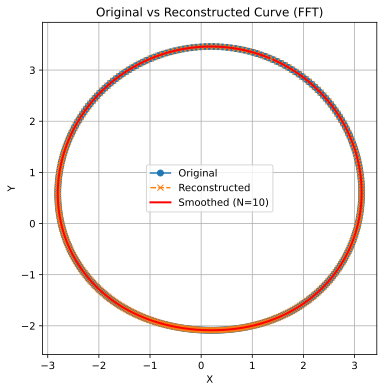

{'total_energy': 65536.0, 'low_energy_ratio': 0.9999999441778353, 'dc_energy_ratio': 7.449595898658412e-33, 'num_power_peaks': 1, 'reconstruction_error_K': 0.00023626714682919433, 'ground_fraction': 0.15625, 'slope_std': 0.0487025750981703, 'is_closed': True}


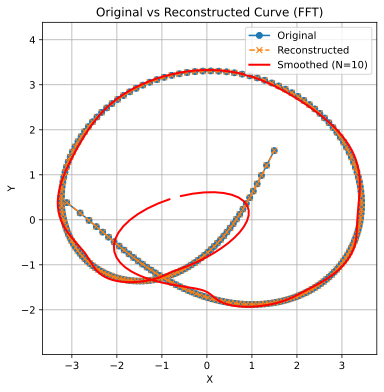

{'total_energy': 65536.0, 'low_energy_ratio': 0.9922345953547256, 'dc_energy_ratio': 2.1294315264015903e-33, 'num_power_peaks': 1, 'reconstruction_error_K': 0.08812153338017605, 'ground_fraction': 0.1015625, 'slope_std': 0.06551377573341602, 'is_closed': False}


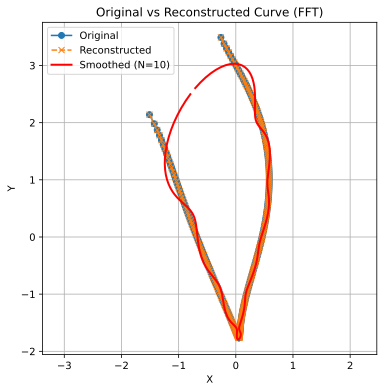

100%|██████████| 30/30 [00:05<00:00,  5.14it/s]

{'total_energy': 65536.00000000003, 'low_energy_ratio': 0.9964810621719702, 'dc_energy_ratio': 1.737968397690751e-33, 'num_power_peaks': 1, 'reconstruction_error_K': 0.05932063576892322, 'ground_fraction': 0.05859375, 'slope_std': 0.0354579063281282, 'is_closed': False}


In [16]:
# Simulation, Normalization, and Storage 

normFailCtr = 0

NUM_MECHS = 30

from scipy.signal import find_peaks

def resample_uniform(points, M):
    # points: (N,2) numpy
    # Return M points uniformly along arc length
    dif = np.diff(points, axis=0)
    seglen = np.sqrt((dif**2).sum(axis=1))
    s = np.concatenate(([0], np.cumsum(seglen)))
    total = s[-1]
    if total == 0:
        return np.repeat(points[:1], M, axis=0)
    s_uniform = np.linspace(0, total, M)
    x = np.interp(s_uniform, s, points[:,0])
    y = np.interp(s_uniform, s, points[:,1])
    return np.column_stack((x, y))

def compute_fd_features(points, K=20, N_resample=256, eps_ground=0.05):
    # 1) Resample uniformly in arc length
    pts = resample_uniform(points, N_resample)
    z = pts[:,0] + 1j*pts[:,1]
    N = z.size

    # 2) Remove DC (translation invariance)
    z = z - np.mean(z)

    # 3) Optionally scale normalization (scale invariance)
    scale = np.sqrt(np.mean(np.abs(z)**2))
    if scale > 0:
        z = z / scale

    # 4) FFT
    Z = np.fft.fft(z)
    power = np.abs(Z)**2
    total_energy = power.sum()

    # energy in first K harmonics (centered on zero freq)
    # We'll use the usual FFT ordering 0..N-1; low freqs are Z[0], Z[1..K], Z[-K+1..]
    low_idxs = np.concatenate([np.arange(1, K+1), np.arange(N-K+1, N)])  # exclude DC=0 in denom
    low_energy = power[low_idxs].sum()
    # include DC separately if you want
    dc_energy = power[0]

    # Dominant peaks in power spectrum (ignore DC)
    freqs_power = power.copy()
    freqs_power[0] = 0
    # convert to magnitudes for peaks
    pk_idxs, _ = find_peaks(freqs_power, height=np.max(freqs_power)*0.1)
    num_peaks = pk_idxs.size

    # reconstruction error using only first K harmonics (symmetrically)
    Z_low = np.zeros_like(Z, dtype=complex)
    Z_low[low_idxs] = Z[low_idxs]
    recon_low = np.fft.ifft(Z_low)
    recon_err = np.linalg.norm(z - recon_low) / (np.linalg.norm(z) + 1e-12)

    # geometric feature: ground fraction near min y
    ys = pts[:,1]
    y_min = ys.min()
    # eps relative to vertical range
    yrange = ys.max()-ys.min() if ys.max()!=ys.min() else 1.0
    ground_mask = (ys - y_min) < (eps_ground * yrange)
    ground_fraction = ground_mask.mean()

    # slope std (discrete derivative)
    dy = np.gradient(ys)
    slope_std = np.std(dy)

    # Check if path is open or closed
    start_pt = pts[0]
    end_pt = pts[-1]
    path_dist = np.linalg.norm(end_pt - start_pt)
    is_closed = path_dist < 0.1

    features = {
        'total_energy': float(total_energy),
        'low_energy_ratio': float(low_energy / (total_energy + 1e-12)),
        'dc_energy_ratio': float(dc_energy / (total_energy + 1e-12)),
        'num_power_peaks': int(num_peaks),
        'reconstruction_error_K': float(recon_err),
        'ground_fraction': float(ground_fraction),
        'slope_std': float(slope_std),
        'is_closed': bool(is_closed)
    }
    return features



for initState in tqdm(initStates[mechType*NUM_MECHS: (mechType+1)*NUM_MECHS, :5*2]):
    coord = np.round(initState, 3).reshape((5,2))
    dist = calc_dist(coord)

    if max(dist) > 10:
        continue

    param = coord.tolist()

    name = str(param).replace("[", "").replace("]", "").replace(",", "") 

    exampleData = {
        'type': types[mechType],  
        'params': param,
        'speedScale':speedscale, # 1 
        'steps':steps, # 360 
        'relativeTolerance':0.1 
    }


    batch.append(exampleData) #... You should use a function to decide save str. 
    batchSaveStr.append(saveDir + '/' + name )       # old method of doing things 
    batchSaveNpyStr.append(saveDirNpy + '/' + name ) # old method of doing things 

    if len(batch) >= batchCount:
        try:
            temp = requests.post(url = API_ENDPOINT, headers=HEADERS, data = json.dumps(batch)).json()
            time.sleep(0.02) # temp is one batch of mechanisms sent to the server to be solved
        except ValueError as v:
            for i in range(3):
                time.sleep(2)
                try:
                    temp = requests.post(url = API_ENDPOINT, headers=HEADERS, data = json.dumps(batch)).json()
                    break
                except ValueError as v2:
                    errCtr += 1
        for i in range(len(temp)):
            P = np.array(temp[i]['poses'])
            try:
                if len(P.shape) >= 1:
                    if P.shape[0] >= minsteps:
                        # do normalization, also get the transformation parameters. 
                        # also the paras are saved instead of MP (M: tranformation matrix, P: points in the matrix)
                        # This is just to avoid decimal difference problem 
                        imageMat, transParamSet, success = process_mech_051524(P, couplerCurveIndex[mechType])
                        if success:
                            # change Tstr if needed 
                            # normalized coords
                            normalized_coords = normalize_data_122223(P[:,couplerCurveIndex[mechType],:], scaling=3.5)[0]
                            #print(normalized_coords)
                            import matplotlib.pyplot as plt

                            '''plt.figure(figsize=(6, 6))
                            plt.plot(normalized_coords[:, 0], normalized_coords[:, 1], marker='o')
                            plt.title('Normalized Coupler Curve')
                            plt.xlabel('X')
                            plt.ylabel('Y')
                            plt.axis('equal')
                            plt.grid(True)
                            plt.show()'''

                            # Compute Fourier descriptors
                            fd = np.fft.fft(normalized_coords[:, 0] + 1j * normalized_coords[:, 1])
                            #print(fd)

                            # Inverse FFT to reconstruct curve
                            reconstructed = np.fft.ifft(fd)
                            reconstructed_coords = np.column_stack((reconstructed.real, reconstructed.imag))

                            # Plot original and reconstructed curves
                            plt.figure(figsize=(6, 6))
                            plt.plot(normalized_coords[:, 0], normalized_coords[:, 1], label='Original', marker='o')
                            plt.plot(reconstructed_coords[:, 0], reconstructed_coords[:, 1], label='Reconstructed', linestyle='--', marker='x')

                             # Use only the first N low-frequency Fourier coefficients for smoothing
                            N = 10  # You can adjust N for more/less smoothing

                            fd_low = np.zeros_like(fd)
                            fd_low[:N] = fd[:N]
                            fd_low[-N+1:] = fd[-N+1:]

                            smoothed = np.fft.ifft(fd_low)
                            smoothed_coords = np.column_stack((smoothed.real, smoothed.imag))

                            plt.plot(smoothed_coords[:, 0], smoothed_coords[:, 1], label=f'Smoothed (N={N})', color='red', linewidth=2)



                            plt.title('Original vs Reconstructed Curve (FFT)')
                            plt.xlabel('X')
                            plt.ylabel('Y')
                            plt.axis('equal')
                            plt.grid(True)
                            plt.legend()
                            plt.show()

                            print(compute_fd_features(normalized_coords))

                           

                            Tstr = np.array2string(np.round(transParamSet, 3), precision=3, suppress_small=True).replace("[", "").replace("]", "") # Wei asked for this part
                            Tstr = re.sub('\s+', ' ', Tstr) # to replace multiple sequential spaces together
                            binary_data = np.uint8(imageMat[:,:,0]) * 255
                            img = Image.fromarray(binary_data)
                            if needAddtional[mechType]: # need additional description (replace old method)
                                pinit = (np.array(temp[i]['posInit'])[:savePointNumber[mechType], :].flatten().tolist())
                                name = format_floats_to_string(pinit)
                                img.save(saveDir + '\\' + name + ' ' + types[mechType] + ' '  + Tstr + '.jpg')
                            else:                       # traditional if no added 
                                img.save(batchSaveStr[i] + ' ' + types[mechType] + ' ' + Tstr + '.jpg')
                            #plt.imshow(imageMat)
                            #plt.savefig(batchSaveStr[i] + Tstr + '.jpg')
                            #plt.clf()
                        else: 
                            normFailCtr += 1
                        pass                        
            except ValueError as v:
                print(v)
            except FileNotFoundError as f:
                print(f)
        batch = []
        batchSaveStr = []
        batchSaveNpyStr = []

if len(batch) >= batchCount:
    #print(batch[0], '\n', batch[1])
    #print(batchSaveStr[0], '\n', batchSaveStr[1])
    try:
        temp = requests.post(url = API_ENDPOINT, headers=HEADERS, data = json.dumps(batch)).json()
        time.sleep(0.02)
    except ValueError as v:
        for i in range(3):
            time.sleep(2)
            try:
                temp = requests.post(url = API_ENDPOINT, headers=HEADERS, data = json.dumps(batch)).json()
                break
            except ValueError as v2:
                    errCtr += 1
    for i in range(len(temp)):
        P = np.array(temp[i]['poses']) 
        try:
            if len(P.shape) >= 1:
                if P.shape[0] >= minsteps:
                    # do normalization, also get the transformation parameters. 
                    # also the paras are saved instead of MP (M: tranformation matrix, P: points in the matrix)
                    # This is just to avoid decimal difference problem 
                    imageMat, transParamSet, success = process_mech_051524(P, couplerCurveIndex[mechType])
                    if success:
                        Tstr = np.array2string(np.round(transParamSet, 3), precision=3, suppress_small=True).replace("[", "").replace("]", "") # Wei asked for this part
                        Tstr = re.sub('\s+', ' ', Tstr) # to replace multiple sequential spaces together
                        binary_data = np.uint8(imageMat[:,:,0]) * 255
                        img = Image.fromarray(binary_data)
                        if needAddtional[mechType]: # need additional description (replace old method)
                            pinit = (np.array(temp[i]['posInit'])[:savePointNumber[mechType], :].flatten().tolist())
                            name = format_floats_to_string(pinit)
                            img.save(saveDir + '\\' + name + ' ' + types[mechType] + ' '  + Tstr + '.jpg')
                        else:                       # traditional if no added 
                            img.save(batchSaveStr[i] + ' ' + types[mechType] + ' '  + Tstr + '.jpg') 
                        #plt.imshow(imageMat)
                        #plt.savefig(batchSaveStr[i] + Tstr + '.jpg')
                        #plt.clf()
                    else:
                        normFailCtr += 1
                        pass       
        except ValueError as v:
            print(v)
        except FileNotFoundError as f:
            print(f)
    batch = []
    batchSaveStr = []
    batchSaveNpyStr = []

In [17]:
print(normFailCtr) # basically not too many steps is the reason. 

0
